## Final Assignment Overview: Working with Patient Records and Encounter Notes

In this final assignment, we’ll focus on patient records related to COVID-19 encounters. Our task is to analyze, process, and transform the data while applying the concepts we’ve covered throughout this course. Here's a detailed breakdown of the assignment:

What Are Encounter Notes?
An encounter note is a record that captures details about a patient’s visit with a doctor. It includes both structured and semi-structured information that is crucial for understanding the context of the visit. Here’s what an encounter note typically looks like:

```
AMBULATORY ENCOUNTER NOTE
Date of Service: March 2, 2020 15:45-16:30

DEMOGRAPHICS:
Name: Jeffrey Greenfelder
DOB: 1/16/2005
Gender: Male
Address: 428 Wiza Glen Unit 91, Springfield, Massachusetts 01104
Insurance: Guardian
MRN: 055ae6fc-7e18-4a39-8058-64082ca6d515

PERTINENT MEDICAL HISTORY:
- Obesity 

Recent Visit: Well child visit (2/23/2020)
Immunizations: Influenza vaccine (2/23/2020)

Recent Baseline (2/23/2020):
Height: 155.0 cm
Weight: 81.2 kg
BMI: 33.8 kg/m² (99.1th percentile)
BP: 123/80 mmHg
HR: 92/min
RR: 13/min

SUBJECTIVE:
Adolescent patient presents with multiple symptoms including:
- Cough
- Sore throat
- Severe fatigue
- Muscle pain
- Joint pain
- Fever
Never smoker. Symptoms began recently.

OBJECTIVE:
Vitals:
Temperature: 39.3°C (102.7°F)
Heart Rate: 131.1/min
Blood Pressure: 120/73 mmHg
Respiratory Rate: 27.6/min
O2 Saturation: 75.8% on room air
Weight: 81.2 kg

Laboratory/Testing:
Comprehensive Respiratory Panel:
- Influenza A RNA: Negative
- Influenza B RNA: Negative
- RSV RNA: Negative
- Parainfluenza virus 1,2,3 RNA: Negative
- Rhinovirus RNA: Negative
- Human metapneumovirus RNA: Negative
- Adenovirus DNA: Negative
- SARS-CoV-2 RNA: Positive

ASSESSMENT:
1. Suspected COVID-19 with severe symptoms
2. Severe hypoxemia requiring immediate intervention
3. Tachycardia (HR 131)
4. High-grade fever
5. Risk factors:
   - Obesity (BMI 33.8)
   - Adolescent age

PLAN:
1. Face mask provided for immediate oxygen support
2. Infectious disease care plan initiated
3. Close monitoring required due to:
   - Severe hypoxemia
   - Tachycardia
   - Age and obesity risk factors
4. Parent/patient education on:
   - Home isolation protocols
   - Warning signs requiring emergency care
   - Return precautions
5. Follow-up plan:
   - Daily monitoring during acute phase
   - Virtual check-ins as needed

Encounter Duration: 45 minutes
Encounter Type: Ambulatory
Provider: ID# e2c226c2-3e1e-3d0b-b997-ce9544c10528
Facility: 5103c940-0c08-392f-95cd-446e0cea042a
```


The enocuter contains

* General encounter information: 

  * When the encounter took place: Date and time of the visit.
  * Demographics: Patient’s age, gender, and unique medical record identifier.
  * Encounter details: The reason for the visit, diagnosis, and any associated costs.


* Semi-Structured Notes:

These notes mirror how doctors organize their thoughts and observations during an encounter. They generally follow a SOAP format:

* Subjective: The patient’s subjective description of their symptoms, feelings, and medical concerns.
* Objective: The doctor’s objective findings, including test results, measurements, or physical examination outcomes.
* Assessment: The doctor’s evaluation or diagnosis based on subjective and objective information.
* Plan: The proposed treatment plan, including medications, follow-ups, or other interventions.

While some encounter notes might include additional details, the majority conform to this semi-structured format, making them ideal for analysis and transformation.

* Goals for the Assignment

1. Transforming Encounter Notes:

Using an LLM to convert semi-structured encounter notes into a JSON format that organizes the information into structured fields. The JSON will include details such as demographics, encounter specifics, and the SOAP components of the note. Subsequently, you will need to transform the JSON data into a Parquet file, which is not only suitable for analysis in Spark but also ideal for storage later.
Here we will use the ML classificaition to assign the objective and assessment semi-structured fields into standardized, structured fields. The medical taxonomy for this task will be the one provided by the CDC, which defines standard codes for diagnoses, symptoms, procedures, and treatments. This step ensures the structured data aligns with domain-wide medical standards, making it interoperable and ready for deeper analysis.

The JSON format should capture the hierachies described in the structure below. 




2. Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 
- An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations


In [ ]:
%pip install openai
%pip install -U sentence-transformers
%pip install faiss-cpu
%pip install numpy==1.26.0 scipy==1.11.1
%restart_python


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [ ]:
# Imports
from pydantic import BaseModel, Field, validator
from typing import Optional, List
from datetime import date, datetime, time, timedelta
from openai import OpenAI
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, when, count, to_date, sum as spark_sum, explode, lower, row_number, desc, floor, concat, lit, udf,avg,round
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Task 1 Transforming Encounter Notes:

Using an LLM to convert semi-structured encounter notes into a JSON format that organizes the information into structured fields. The JSON will include details such as demographics, encounter specifics, and the SOAP components of the note. Subsequently, you will need to transform the JSON data into a Parquet file, which is not only suitable for analysis in Spark but also ideal for storage later.
Here we will use the ML classificaition to assign the objective and assessment semi-structured fields into standardized, structured fields. The medical taxonomy for this task will be the one provided by the CDC, which defines standard codes for diagnoses, symptoms, procedures, and treatments. This step ensures the structured data aligns with domain-wide medical standards, making it interoperable and ready for deeper analysis.

**Find the fields that are possible to extract from purely the notes**

```
EncounterType:
    code: False
    description: True

Encounter:
    date: True
    time: True
    type: EncounterType: True
    provider_id: True
    facility_id: True

Address:
    city: True
    state: True

Demographics:
    id: True -- MRN
    name: True
    date_of_birth: True
    age: Infered from date_of_birth
    gender: True
    address: Address: True
    insurance: True

Condition:
    code: False
    description: True

Medication:
    code: False
    description: True

Immunization:
    code: False
    description: True
    date: True

VitalMeasurement:
    code: False
    value: True
    unit: True

BloodPressure:
    systolic: VitalMeasurement: True
    diastolic: VitalMeasurement: True

CurrentVitals:
    temperature: VitalMeasurement: True
    heart_rate: VitalMeasurement: True
    blood_pressure: BloodPressure: True
    respiratory_rate: VitalMeasurement: True
    oxygen_saturation: VitalMeasurement: True
    weight: VitalMeasurement: True

BaselineVitals:
    date: True
    height: VitalMeasurement: True
    weight: VitalMeasurement: True
    bmi: VitalMeasurement: True
    bmi_percentile: VitalMeasurement: True

Vitals:
    current: CurrentVitals: True
    baseline: BaselineVitals: True

RespiratoryTest:
    code: False
    result True

RespiratoryPanel:
    influenza_a: RespiratoryTest: True
    influenza_b: RespiratoryTest: True
    rsv: RespiratoryTest: True
    parainfluenza_1: RespiratoryTest: True
    parainfluenza_2: RespiratoryTest: True
    parainfluenza_3: RespiratoryTest: True
    rhinovirus: RespiratoryTest: True
    metapneumovirus: RespiratoryTest: True
    adenovirus: RespiratoryTest: True

Covid19Test:
    code: False
    description: True
    result: True

Laboratory:
    covid19: Covid19Test: True
    respiratory_panel: RespiratoryPanel: True

Procedure:
    code: False
    description: False
    date: False
    reasonCode: False
    reasonDescription: False

CarePlan:
    id: False
    code: False
    description: True
    start: False
    stop: False
    reasonCode: False
    reasonDescription: False

PatientRecord:
    encounter: Encounter: True
    demographics: Demographics: True
    conditions: List[Condition]: True
    medications: List[Medication]: True
    immunizations: List[Immunization]: True
    vitals: Vitals: True
    laboratory: Laboratory: True
    procedures: List[Procedure]: True
```


**Using all fields in as a structured output LLM query was not possible, as there were > 105 parameters, and 100, is the max limit.**

Instead I decided to filter out the information that cannot be found in the notes, and then instead add this after, using the additional CSV files, and pydantic

Most of the Models have 2 versions. a "full" and a "minimal". 

The minimal version will be used for prompting the LLM

The full version will be used to convert the output of the LLM back to have all the required fields

In [ ]:
class EncounterTypeMinimal(BaseModel):
  # code: # not found in note
  description: str = Field(
    ...,
    description="Typically found at the top of the note"
  )

class EncounterType(BaseModel):
  code: Optional[str] = Field(None)
  description: str = Field(...)

class EncounterMinimal(BaseModel):
  encounter_date: str = Field(
    ...,
    description="Typically found near the top of the note. format YYYY-MM-DD",
    alias="date"
  )
  encounter_time: str = Field(
    ...,
    description="Typically found near the top of the note. format hh:mm:ss",
    alias="time"
  )
  encounter_type: EncounterTypeMinimal = Field(
    ...,
    description="Typically found near the bottom of the note",
    alias="type"
  )
  provider_id: str = Field(
    ...,
    description="Typically found near the bottom of the note"
  )
  facility_id: str = Field(
    ...,
    description="Typically found near the bottom of the note"
  )

class Encounter(BaseModel):
  encounter_date: str = Field(
    ...,
    alias="date"
  )
  encounter_time: str = Field(
    ...,
    alias="time"
  )
  encounter_type: EncounterType = Field(
    ...,
    alias="type"
  )
  provider_id: str = Field(
    ...,
  )
  facility_id: str = Field(
    ...,
  )

class Address(BaseModel):
  city: str = Field(
    ...,
    description="The address of the patient. Typically found under DEMOGRAPHICS header"
  )
  state: str = Field(
    ...,
    description="The state the patient lives in. Typically found under DEMOGRAPHICS header"
  )

class Demographics(BaseModel):
  id: str = Field(
    ...,
    description="The patient ID. Typically found under DEMOGRAPHICS header as MRN"
  )
  name: str = Field(
    ...,
    description="The name of the patient. Typically found under DEMOGRAPHICS header"
  )
  date_of_birth: str = Field (
    ...,
    description="The date of birth of the patient. Typically found under DEMOGRAPHICS header. format YYYY-MM-DD"
  )
  age: int = Field(
    None
  )
  gender: str = Field (
    ...,
    description="The gender of the patient. Typically found under DEMOGRAPHICS header. format M | F"
  )
  address: Address = Field(
    ...,
    description="The address of the patient."
  )
  insurance: str = Field(
    ...,
    description="The insurance holder of the patient. Typically found under DEMOGRAPHICS header"
  )

  @validator('age', pre=True, always=True)
  def calculate_age(cls, value, values):
    dob_str = values.get('date_of_birth')
    if dob_str:
      try:
        dob = datetime.strptime(dob_str, '%Y-%m-%d').date()
      except ValueError:
        raise ValueError("date_of_birth must be in YYYY-MM-DD format")

      today = date.today()
      years = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
      return years
    raise ValueError("Date of birth is required to calculate age")

class ConditionMinimal(BaseModel):
  # code: # not found in note
  description: str = Field(
    ...,
    description="Typically found under PERTINENT MEDICAL HISTORY or ASSESSMENT sections of the note"
  )

class Condition(BaseModel):
  code: Optional[str] = Field(None)
  description: str = Field(...)

class MedicationMinimal(BaseModel):
  # code: # not found in document
  description: str = Field(
    ...,
    description="The medications the patient currently takes. Typically found under Current Medications section of the note"
  )

class Medication(BaseModel):
  code: Optional[str] = Field(None)
  description: str = Field(...)

class ImmunizationMinimal(BaseModel):
  # code: # not found in note
  description: str = Field(
    ...,
    description="Typically found under the Immunizations heading in the note"
  )
  date: str = Field(
    ...,
    description="Typically found alongside the immunization details. format YYYY-MM-DD"
  )

class Immunization(BaseModel):
  code: Optional[str] = Field(None)
  description: str = Field(...)
  date: str = Field(...)

class VitalMeasurementMinimal(BaseModel):
  # code: # not found in note
  value: float = Field(
    ...,
    description="Typically found under the OBJECTIVE Vitals section of the note"
  )
  unit: str = Field(
    ...,
    description="Typically found alongside the value in the OBJECTIVE Vitals section"
  )

class VitalMeasurement(BaseModel):
  code: Optional[str] = Field(None)
  value: float = Field(...)
  unit: str = Field(...)

class BloodPressureMinimal(BaseModel):
  systolic: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section (systolic measurement)"
  )
  diastolic: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section (diastolic measurement)"
  )

class BloodPressure(BaseModel):
  systolic: VitalMeasurement = Field(...)
  diastolic: VitalMeasurement = Field(...)

class CurrentVitalsMinimal(BaseModel):
  temperature: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section"
  )
  heart_rate: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section"
  )
  blood_pressure: BloodPressureMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section"
  )
  respiratory_rate: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section"
  )
  oxygen_saturation: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section"
  )
  weight: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals section"
  )

class CurrentVitals(BaseModel):
  temperature: VitalMeasurement = Field(...)
  heart_rate: VitalMeasurement = Field(...)
  blood_pressure: BloodPressure = Field(...)
  respiratory_rate: VitalMeasurement = Field(...)
  oxygen_saturation: VitalMeasurement = Field(...)
  weight: VitalMeasurement = Field(...)

class BaselineVitalsMinimal(BaseModel):
  date: str = Field(
    ...,
    description="Typically found in the Recent Baseline section. format YYYY-MM-DD"
  )
  height: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the Recent Baseline or historical vitals section"
  )
  weight: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the Recent Baseline or historical vitals section"
  )
  bmi: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the Recent Baseline or historical vitals section"
  )
  bmi_percentile: VitalMeasurementMinimal = Field(
    ...,
    description="Typically found in the Recent Baseline or historical vitals section"
  )

class BaselineVitals(BaseModel):
  date: str = Field(...)
  height: VitalMeasurement = Field(...)
  weight: VitalMeasurement = Field(...)
  bmi: VitalMeasurement = Field(...)
  bmi_percentile: VitalMeasurement = Field(...)

class VitalsMinimal(BaseModel):
  current: CurrentVitalsMinimal = Field(
    ...,
    description="Typically found under the OBJECTIVE Vitals section"
  )
  baseline: Optional[BaselineVitalsMinimal] = Field(
    None,
    description="Typically found in the Recent Baseline vitals section"
  )

class Vitals(BaseModel):
  current: CurrentVitals = Field(...)
  baseline: Optional[BaselineVitals] = Field(None)

class RespiratoryTestMinimal(BaseModel):
  # code: not found in note
  result: str = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under respiratory panel results"
  )

class RespiratoryTest(BaseModel):
  code: Optional[str] = Field(None)
  result: str = Field(...)

class RespiratoryPanelMinimal(BaseModel):
  influenza_a: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  influenza_b: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  rsv: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  parainfluenza_1: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  parainfluenza_2: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  parainfluenza_3: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  rhinovirus: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  metapneumovirus: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )
  adenovirus: RespiratoryTestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )

class RespiratoryPanel(BaseModel):
  influenza_a: RespiratoryTest = Field(...)
  influenza_b: RespiratoryTest = Field(...)
  rsv: RespiratoryTest = Field(...)
  parainfluenza_1: RespiratoryTest = Field(...)
  parainfluenza_2: RespiratoryTest = Field(...)
  parainfluenza_3: RespiratoryTest = Field(...)
  rhinovirus: RespiratoryTest = Field(...)
  metapneumovirus: RespiratoryTest = Field(...)
  adenovirus: RespiratoryTest = Field(...)

class Covid19TestMinimal(BaseModel):
  # code: # not found in note
  description: str = Field(
    ...,
    description="Typically found in the Laboratory/Testing section as details for COVID-19 PCR"
  )
  result: str = Field(
    ...,
    description="Typically found in the Laboratory/Testing section as the outcome of the COVID-19 test"
  )

class Covid19Test(BaseModel):
  code: Optional[str] = Field(None)
  description: str = Field(...)
  result: str = Field(...)

class LaboratoryMinimal(BaseModel):
  covid19: Covid19TestMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under COVID-19 results"
  )
  respiratory_panel: RespiratoryPanelMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section under the Respiratory Panel"
  )

class Laboratory(BaseModel):
  covid19: Covid19Test = Field(...)
  respiratory_panel: RespiratoryPanel = Field(...)

class ProcedureMinimal(BaseModel):
  # code: # not found in note
  description: str = Field(
    ...,
    description="Typically found under Recent Procedures or mentioned in the PLAN section"
  )
  Procedure_date: str = Field(
    ...,
    description="Typically found alongside procedure details. format YYYY-MM-DD",
    alias="date"
  )
  # reasonCode: # not found in note
  # reasonDescription: # not found in note

class Procedure(BaseModel):
  code: Optional[str] = Field(None)
  description: str = Field(...)
  Procedure_date: str = Field(
    ...,
    alias="date"
  )
  reasonCode: Optional[str] = Field(None)
  reasonDescription: Optional[str] = Field(None)

class CarePlanMinimal(BaseModel):
  # id: # not found in note
  # code: # not found in note
  description: str = Field(
    ...,
    description="Typically found in the PLAN section of the note"
  )
  # start: # not found in note
  # stop: # not found in note
  # reasonCode: # not found in note
  # reasonDescription: # not found in note

class CarePlan(BaseModel):
  id: Optional[str] = Field(None)
  code: Optional[str] = Field(None)
  description: str = Field(...)
  start: Optional[str] = Field(None)
  stop: Optional[str] = Field(None)
  reasonCode: Optional[str] = Field(None)
  reasonDescription: Optional[str] = Field(None)

class PatientRecordMinimal(BaseModel):
  encounter: EncounterMinimal = Field(
    ...,
    description="Summarizes encounter details typically found at top and bottom of the note"
  )
  demographics: Demographics = Field(
    ...,
    description="Typically found under the DEMOGRAPHICS header"
  )
  conditions: List[ConditionMinimal] = Field(
    ...,
    description="Typically found under PERTINENT MEDICAL HISTORY or ASSESSMENT"
  )
  medications: List[MedicationMinimal] = Field(
    ...,
    description="The medications the patient currently takes. Typically found under Current Medications section. NOT the reccomened medications listed under Plan"
  )
  immunizations: List[ImmunizationMinimal] = Field(
    ...,
    description="Typically found under the Immunizations heading"
  )
  vitals: VitalsMinimal = Field(
    ...,
    description="Typically found in the OBJECTIVE Vitals or Recent Baseline sections"
  )
  laboratory: LaboratoryMinimal = Field(
    ...,
    description="Typically found in the Laboratory/Testing section"
  )
  procedures: List[ProcedureMinimal] = Field(
    ...,
    description="Typically found under Recent Procedures or in the PLAN section"
  )

class PatientRecord(BaseModel):
  encounter: Encounter = Field(...)
  demographics: Demographics = Field(...)
  conditions: List[Condition] = Field(...)
  medications: List[Medication] = Field(...)
  immunizations: List[Immunization] = Field(...)
  vitals: Vitals = Field(...)
  laboratory: Laboratory = Field(...)
  procedures: List[Procedure] = Field(...)


**Load the encounter notes**

In [ ]:
folder_path = "/FileStore/tables/encounter_notes/"
file_paths = [file.path for file in dbutils.fs.ls(folder_path)]

encounter_notes = [
    "".join([row.value + "\n" for row in spark.read.text(file_path).collect()])
    for file_path in file_paths
]

print(len(encounter_notes))
print(encounter_notes[0])


11
AMBULATORY ENCOUNTER NOTE
Date of Service: March 2, 2020 15:45-16:30

DEMOGRAPHICS:
Name: Jeffrey Greenfelder
DOB: 1/16/2005
Gender: Male
Address: 428 Wiza Glen Unit 91, Springfield, Massachusetts 01104
Insurance: Guardian
MRN: 055ae6fc-7e18-4a39-8058-64082ca6d515

PERTINENT MEDICAL HISTORY:
- Obesity (diagnosed 2017)

Recent Visit: Well child visit (2/23/2020)
Immunizations: Influenza vaccine (2/23/2020)

Recent Baseline (2/23/2020):
Height: 155.0 cm
Weight: 81.2 kg
BMI: 33.8 kg/m² (99.1th percentile)
BP: 123/80 mmHg
HR: 92/min
RR: 13/min

SUBJECTIVE:
Adolescent patient presents with multiple symptoms, including cough, sore throat, severe fatigue, muscle pain, joint pain, and fever. The patient has no history of smoking and reports that the symptoms began recently.


OBJECTIVE:
Vitals:
Temperature: 39.3°C (102.7°F)
Heart Rate: 131.1/min
Blood Pressure: 120/73 mmHg
Respiratory Rate: 27.6/min
O2 Saturation: 75.8% on room air
Weight: 81.2 kg (stable)

Laboratory/Testing:
Comprehensive

**Set up the OpenAI client**

In [ ]:
client = OpenAI(
  api_key="some_key"
)

**test an LLM query with the second note**

In [ ]:
test_response = client.beta.chat.completions.parse(
  messages=[
    {
      "role": "system", 
      "content": "You are a helpful assistant that extracts key information from medical notes."
    },
    {
      "role": "user",
      "content": f"Extract the information in the note: \n {encounter_notes[1]}"
    }
  ],
  model="gpt-4o-2024-08-06",
  temperature=0, # for getting the most accurate output
  response_format=PatientRecordMinimal
)

# get the content of the output
minimal_data = test_response.choices[0].message.content

# prase the output as a minimal patient record
pr_minimal = PatientRecordMinimal.parse_raw(minimal_data)

# add the missing fields with default values
pr_full_test = PatientRecord(**pr_minimal.dict(by_alias=True))

# print it in a human readable style
print(json.dumps(pr_full_test.dict(by_alias=True), indent=2))


{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": null,
      "description": "Ambulatory/Urgent Care"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Otherwise

**This works, now create a function that takes an encounter_note as an argument, and returns an PatientRecord**

In [ ]:
def generateMinimalPatientRecord(note:str):
  """
  generates an patientRecord from an encounter note

  Args:
    note (str): an encounter note

  Returns:
    (PatientRecord): with only the information from the encounter note
  """
  completion = client.beta.chat.completions.parse(
  messages=[
    {
      "role": "system", 
      "content": "You are a helpful assistant that extracts key information from medical notes."
    },
    {
      "role": "user",
      "content": f"Extract the information in the note: \n {note}"
    }
  ],
  model="gpt-4o-2024-08-06",
  temperature=0, # for getting the most accurate output
  response_format=PatientRecordMinimal
  )

  # get the content of the output
  minimal_data = completion.choices[0].message.content

  # prase the output as a minimal patient record
  pr_minimal = PatientRecordMinimal.parse_raw(minimal_data)

  # add the missing fields with default values
  pr_full = PatientRecord(**pr_minimal.dict(by_alias=True))

  return pr_full



**test it**

In [ ]:
print(json.dumps(generateMinimalPatientRecord(encounter_notes[1]).dict(by_alias=True), indent=2))


{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": null,
      "description": "Ambulatory/Urgent Care"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Otherwise

**Create a simple function to display the json in a nice format**

In [ ]:

def showPatientRecord(patient_record:PatientRecord):
  """
  displays a patient record, in a human readable format, using aliases

  Args:
    patient_record (PatientRecord): The patient record to be displayed
  """
  print(json.dumps(patient_record.dict(by_alias=True), indent=2))

**Load the rest of the CSV files**

In [ ]:
# create a dataframe containing the encounters
encounters_df = spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("dbfs:/FileStore/tables/encounters_assignment_1.csv")

# create a dataframe containing the encounter types
encounters_types_df = spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("dbfs:/FileStore/tables/encounters_types_assignment_1.csv")

# create a dataframe containing the medications
medications_df = spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("dbfs:/FileStore/tables/medications_assignment_1.csv")

# create a dataframe containing the observations
observations_df = spark.read.format("csv") \
  .option("header", "false") \
  .option("inferSchema", "true") \
  .load("dbfs:/FileStore/tables/observations_assignment_1.csv")

# create a dataframe containing the immunizations
immunizations_df = spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("dbfs:/FileStore/tables/immunizations_assignment_1.csv")

**Verify that they are loaded correctly**

In [ ]:
print(encounters_df.head(3), '\n')
print(encounters_types_df.head(3), '\n')
print(medications_df.head(3), '\n')
print(observations_df.head(3), '\n')
print(immunizations_df.head(3), '\n')

[Row(PATIENT='f0f3bc8d-ef38-49ce-a2bd-dfdda982b271', START=datetime.datetime(2019, 2, 16, 1, 2, 32), CODE=185345009), Row(PATIENT='f0f3bc8d-ef38-49ce-a2bd-dfdda982b271', START=datetime.datetime(2019, 8, 2, 1, 2, 32), CODE=410620009), Row(PATIENT='f0f3bc8d-ef38-49ce-a2bd-dfdda982b271', START=datetime.datetime(2019, 10, 31, 1, 2, 32), CODE=185345009)] 

[Row(CODE=1505002, DESCRIPTION='Hospital admission for isolation (procedure)'), Row(CODE=162673000, DESCRIPTION='General examination of patient (procedure)'), Row(CODE=169762003, DESCRIPTION='Postnatal visit')] 

[Row(CODE=1000126, DESCRIPTION='1 ML medroxyPROGESTERone acetate 150 MG/ML Injection'), Row(CODE=1000126, DESCRIPTION='1 ML medroxyprogesterone acetate 150 MG/ML Injection'), Row(CODE=1014676, DESCRIPTION='cetirizine hydrochloride 5 MG Oral Tablet')] 

[Row(_c0='10230-1', _c1='Left ventricular Ejection fraction'), Row(_c0='10480-2', _c1='Estrogen+Progesterone receptor Ag [Presence] in Tissue by Immune stain'), Row(_c0='10834-0', 

**Now its time to start populating the PatientRecord**

In [ ]:
# Add the encounter Code

def add_encounter_code(patient_record: PatientRecord, time_tolerance=timedelta(hours=1)):
  """
  adds the encounter_code if possible

  Args:
    patient_record (PatientRecord): The patient record to be updated
    time_tolernace (int): the Tolerable time difference in micro seconds

  Returns:
    PatientRecord: The Updated Patient Record
  """

  # Extract necessary fields
  patient_id = patient_record.demographics.id
  encounter_date = patient_record.encounter.encounter_date
  encounter_time = patient_record.encounter.encounter_time
  
  # Construct encounter datetime (naive)
  encounter_dt_str = f"{encounter_date} {encounter_time}"
  encounter_dt = datetime.strptime(encounter_dt_str, "%Y-%m-%d %H:%M:%S")
  
  # Filter encounters by patient
  patient_encounters = encounters_df.filter(encounters_df["PATIENT"] == patient_id).collect()
  if not patient_encounters:
    # No encounters for this patient
    return patient_record

  # Find the encounter whose START is closest to encounter_dt
  best_row = None
  best_diff = timedelta.max
  
  for row in patient_encounters:
    start_dt = row["START"]
    
    diff = abs(start_dt - encounter_dt)
    if diff < best_diff:
      best_diff = diff
      best_row = row
  
  # Check if the best match is within the 1-hour tolerance
  if best_diff <= time_tolerance and best_row:
    encounter_code = best_row["CODE"]
    patient_record.encounter.encounter_type.code = encounter_code

  return patient_record


**Test it**

In [ ]:
pr_code_test = add_encounter_code(pr_full_test)
showPatientRecord(pr_code_test)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Ambulatory/Urgent Care"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Othe

The code here is the same I see with the command:
```sh
cat encounters_assignment_1.csv | grep 199c586f-af16-4091-9998-ee4cfc02ee7a | grep 2020-03-02
```
**So this does seem to work**

Next step.

Overwrite the encounter description if the code is present

In [ ]:
def update_encounter_description(patient_record: PatientRecord):
  """
  If the patient_record has an encounter.encounter_type.code, 
  look up its description in encounters_types_df and overwrite it.
  
  Args:
      patient_record (PatientRecord): The patient record to be updated.
  
  Returns:
      PatientRecord: The updated PatientRecord.
  """
  encounter_code = patient_record.encounter.encounter_type.code
  if encounter_code is not None:
    # Look up the description in encounters_types_df
    match = encounters_types_df.filter(encounters_types_df["CODE"] == encounter_code).collect()
    if match:
      new_description = match[0]["DESCRIPTION"]
      patient_record.encounter.encounter_type.description = new_description
  return patient_record

**Test it**

In [ ]:
pr_desc_test = update_encounter_description(pr_code_test)
showPatientRecord(pr_desc_test)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Other

**This does also seem to work**

Next Identify this still missing fields

In [ ]:
def find_none_fields(data, path=""):
  """
  prints the None fields in the data

  Args
    data: The data to find the None fields in
    path: the path to the current position in the data. (Used for recursion)
  """
  if isinstance(data, dict):
    for k, v in data.items():
        new_path = f"{path}.{k}" if path else k
        if v is None:
          print(f"{new_path} is None")
        else:
          find_none_fields(v, new_path)
  elif isinstance(data, list):
    for i, item in enumerate(data):
      new_path = f"{path}[{i}]"
      find_none_fields(item, new_path)

find_none_fields(pr_desc_test.dict())

conditions[0].code is None
conditions[1].code is None
conditions[2].code is None
conditions[3].code is None
conditions[4].code is None
medications[0].code is None
immunizations[0].code is None
immunizations[1].code is None
vitals.current.temperature.code is None
vitals.current.heart_rate.code is None
vitals.current.blood_pressure.systolic.code is None
vitals.current.blood_pressure.diastolic.code is None
vitals.current.respiratory_rate.code is None
vitals.current.oxygen_saturation.code is None
vitals.current.weight.code is None
vitals.baseline.height.code is None
vitals.baseline.weight.code is None
vitals.baseline.bmi.code is None
vitals.baseline.bmi_percentile.code is None
laboratory.covid19.code is None
laboratory.respiratory_panel.influenza_a.code is None
laboratory.respiratory_panel.influenza_b.code is None
laboratory.respiratory_panel.rsv.code is None
laboratory.respiratory_panel.parainfluenza_1.code is None
laboratory.respiratory_panel.parainfluenza_2.code is None
laboratory.respi

**Now that we know which fields are still missing. we can start addressing them**

Lets start withthe medications

In [ ]:
# create a faiss index

model = SentenceTransformer('all-MiniLM-L6-v2')
medications_df_pd = medications_df.toPandas()
known_descriptions = medications_df_pd['DESCRIPTION'].tolist()
known_embeddings = model.encode(known_descriptions, convert_to_numpy=True, normalize_embeddings=True)

index_meds = faiss.IndexFlatIP(known_embeddings.shape[1])
index_meds.add(known_embeddings)



In [ ]:
patient_med_descriptions = [m.description for m in pr_desc_test.medications]
patient_med_embeddings = model.encode(patient_med_descriptions, convert_to_numpy=True, normalize_embeddings=True)

distances, indices = index_meds.search(patient_med_embeddings, k=1)
distances, indices

(array([[0.5407707]], dtype=float32), array([[137]]))

In [ ]:
match = medications_df_pd.iloc[indices[0][0]]
match

CODE                          757594
DESCRIPTION    Jolivette 28 Day Pack
Name: 137, dtype: object

In [ ]:
def update_medication_codes(patient_record: PatientRecord, threshold = 0.3):
  """
  Updates the medication codes for medications that currently have None for code.
  Uses a pre-built FAISS index and sentence embeddings model to find the closest known medication.
  
  Args:
    patient_record (PatientRecord): The patient record to update.
    threshold (float, defualt 0.3): The threshold for which the distance has to exceed in order to find the code valid

  Returns:
    PatientRecord: The updated patient record with medication codes filled in when possible.
  """
  # Extract medication descriptions from the patient record for those with None codes
  meds_to_update = [(i, m.description) for i, m in enumerate(patient_record.medications) if m.code is None and m.description is not None]
  
  if not meds_to_update:
    # Nothing to update
    return patient_record

  # Encode only the medications we need to update
  descriptions = [desc for _, desc in meds_to_update]
  new_embeddings = model.encode(descriptions, convert_to_numpy=True, normalize_embeddings=True)

  # Search the FAISS index
  distances, indices = index_meds.search(new_embeddings, k=1)

  # For each medication that needs an update, assign the code from the best match
  for (med_index, _), idx in zip(meds_to_update, indices):
    best_match_index = idx[0]
    matched_row = medications_df_pd.iloc[best_match_index]
    found_code = matched_row['CODE']

    if best_match_index >= threshold:
      # Update the medication code in the patient record
      patient_record.medications[med_index].code = str(found_code)

  return patient_record


In [ ]:
pr_med_codes_test = update_medication_codes(pr_desc_test)
showPatientRecord(pr_med_codes_test)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Other

**This does seem to work**

Next try the same for the immunizations

In [ ]:
immunizations_df_pd = medications_df.toPandas()

known_descriptions = immunizations_df_pd['DESCRIPTION'].tolist()
known_embeddings = model.encode(known_descriptions, convert_to_numpy=True, normalize_embeddings=True)

index_immunizations = faiss.IndexFlatIP(known_embeddings.shape[1])
index_immunizations.add(known_embeddings)


In [ ]:
def update_immunization_codes(patient_record: PatientRecord, threshold = 0.3):
  """
  Updates the immunization codes for immunizations that currently have None for code.
  Uses a pre-built FAISS index and sentence embeddings model to find the closest known immunization.
  
  Args:
    patient_record (PatientRecord): The patient record to update.
    threashold (float, defualt 0.3): The threashold for which the distance has to exceed in order to find the code valid

  Returns:
    PatientRecord: The updated patient record with immunization codes filled in when possible.
  """
  # Extract immunization descriptions that need updating (None codes)
  immuns_to_update = [(i, imm.description) for i, imm in enumerate(patient_record.immunizations) if imm.code is None and imm.description is not None]

  if not immuns_to_update:
    # Nothing to update
    return patient_record

  # Encode only the immunizations we need to update
  descriptions = [desc for _, desc in immuns_to_update]
  new_embeddings = model.encode(descriptions, convert_to_numpy=True, normalize_embeddings=True)

  # Search the FAISS index for immunizations
  distances, indices = index_immunizations.search(new_embeddings, k=1)

  # For each immunization needing an update, assign the code from the best match if threshold is met
  for i, ((imm_index, _), idx) in enumerate(zip(immuns_to_update, indices)):
    best_match_index = idx[0]
    matched_row = immunizations_df_pd.iloc[best_match_index]
    found_code = matched_row['CODE']

    # Check if the similarity meets or exceeds the threshold
    if distances[i][0] >= threshold:
      # Update the medication code in the patient record
      patient_record.immunizations[imm_index].code = str(found_code)

  return patient_record


In [ ]:
pr_immunization_codes_test = update_immunization_codes(pr_med_codes_test, threshold=0.3)
showPatientRecord(pr_immunization_codes_test)



{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Other

**This does seem to work well**

Now for the next observations

In [ ]:
observations_df_pd = observations_df.toPandas()
observations_df_pd.rename(columns={"_c0": "CODE", "_c1": "DESCRIPTION"}, inplace=True)

known_descriptions = observations_df_pd['DESCRIPTION'].tolist()
known_embeddings = model.encode(known_descriptions, convert_to_numpy=True, normalize_embeddings=True)

observations_index = faiss.IndexFlatIP(known_embeddings.shape[1])
observations_index.add(known_embeddings)

In [ ]:
def update_vital_codes(patient_record: PatientRecord, threshold=0.3):
  """
  Updates the vital sign codes for vitals that currently have None for code.
  Uses a pre-built FAISS index and sentence embeddings model to find the closest known observation.
  
  Args:
    patient_record (PatientRecord): The patient record to update.
    threshold (float, default 0.3): The threshold for the similarity distance. 
                                    The returned code is considered valid only if the distance is >= this threshold.

  Returns:
    PatientRecord: The updated patient record with vital codes filled in when possible.
  """
  # A mapping of vital field names to a descriptive phrase that might appear in the observations.
  vital_descriptions = {
    'temperature': "temperature measurement",
    'heart_rate': "heart rate",
    'blood_pressure_systolic': "systolic blood pressure",
    'blood_pressure_diastolic': "diastolic blood pressure",
    'respiratory_rate': "respiratory rate",
    'oxygen_saturation': "oxygen saturation",
    'weight_current': "body weight",
    'height_baseline': "body height",
    'weight_baseline': "body weight",
    'bmi_baseline': "body mass index",
    'bmi_percentile_baseline': "bmi percentile"
  }

  # For each vital sign that does not have a code, we will:
  # 1. Encode the description.
  # 2. Search in the FAISS index.
  # 3. Update the code if the best match meets the threshold.
  def find_code_for_description(description: str, threshold: float):
    if not description:
      return None
    desc_embedding = model.encode([description], convert_to_numpy=True, normalize_embeddings=True).astype('float32')
    distances, indices = observations_index.search(desc_embedding, k=1)
    if distances[0][0] >= threshold:
      matched_row = observations_df_pd.iloc[indices[0][0]]
      return str(matched_row['CODE'])
    return None

  # Update current vitals
  if patient_record.vitals.current.temperature.code is None:
    patient_record.vitals.current.temperature.code = find_code_for_description(vital_descriptions['temperature'], threshold)
  
  if patient_record.vitals.current.heart_rate.code is None:
    patient_record.vitals.current.heart_rate.code = find_code_for_description(vital_descriptions['heart_rate'], threshold)
  
  if patient_record.vitals.current.blood_pressure.systolic.code is None:
    patient_record.vitals.current.blood_pressure.systolic.code = find_code_for_description(vital_descriptions['blood_pressure_systolic'], threshold)
  
  if patient_record.vitals.current.blood_pressure.diastolic.code is None:
    patient_record.vitals.current.blood_pressure.diastolic.code = find_code_for_description(vital_descriptions['blood_pressure_diastolic'], threshold)
  
  if patient_record.vitals.current.respiratory_rate.code is None:
    patient_record.vitals.current.respiratory_rate.code = find_code_for_description(vital_descriptions['respiratory_rate'], threshold)
  
  if patient_record.vitals.current.oxygen_saturation.code is None:
    patient_record.vitals.current.oxygen_saturation.code = find_code_for_description(vital_descriptions['oxygen_saturation'], threshold)
  
  if patient_record.vitals.current.weight.code is None:
    patient_record.vitals.current.weight.code = find_code_for_description(vital_descriptions['weight_current'], threshold)

  # Update baseline vitals
  if patient_record.vitals.baseline.height.code is None:
    patient_record.vitals.baseline.height.code = find_code_for_description(vital_descriptions['height_baseline'], threshold)
  
  if patient_record.vitals.baseline.weight.code is None:
    patient_record.vitals.baseline.weight.code = find_code_for_description(vital_descriptions['weight_baseline'], threshold)
  
  if patient_record.vitals.baseline.bmi.code is None:
    patient_record.vitals.baseline.bmi.code = find_code_for_description(vital_descriptions['bmi_baseline'], threshold)
  
  if patient_record.vitals.baseline.bmi_percentile.code is None:
    patient_record.vitals.baseline.bmi_percentile.code = find_code_for_description(vital_descriptions['bmi_percentile_baseline'], threshold)
  
  return patient_record




In [ ]:
pr_vital_codes_test = update_vital_codes(pr_immunization_codes_test, threshold=0.3)
showPatientRecord(pr_vital_codes_test)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Other

In [ ]:
def update_respiratory_codes(patient_record: PatientRecord, threshold=0.3):
  """
  Updates the respiratory panel laboratory codes (and COVID-19) for tests that currently have None for code.
  Uses a pre-built FAISS index and sentence embeddings model to find the closest known observation.
  
  Args:
    patient_record (PatientRecord): The patient record to update.
    threshold (float, default 0.3): The threshold for the similarity distance.
                                    The returned code is considered valid only if the distance is >= this threshold.

  Returns:
    PatientRecord: The updated patient record with respiratory panel lab codes filled in when possible.
  """
  # Mapping of respiratory panel tests to descriptive phrases
  resp_descriptions = {
    'influenza_a': "influenza a test",
    'influenza_b': "influenza b test",
    'rsv': "rsv test",
    'parainfluenza_1': "parainfluenza 1 test",
    'parainfluenza_2': "parainfluenza 2 test",
    'parainfluenza_3': "parainfluenza 3 test",
    'rhinovirus': "rhinovirus test",
    'metapneumovirus': "metapneumovirus test",
    'adenovirus': "adenovirus test",
    'covid19': "COVID-19 PCR test"
  }

  def find_code_for_description(description: str, threshold: float):
    if not description:
      return None
    desc_embedding = model.encode([description], convert_to_numpy=True, normalize_embeddings=True).astype('float32')
    distances, indices = observations_index.search(desc_embedding, k=1)
    if distances[0][0] >= threshold:
      matched_row = observations_df_pd.iloc[indices[0][0]]
      return str(matched_row['CODE'])
    return None

  lab = patient_record.laboratory
  rp = lab.respiratory_panel

  # Update COVID-19 code if None
  if lab.covid19.code is None:
    lab.covid19.code = find_code_for_description(resp_descriptions['covid19'], threshold)

  # Update codes for each respiratory panel test if None
  if rp.influenza_a.code is None:
    rp.influenza_a.code = find_code_for_description(resp_descriptions['influenza_a'], threshold)
  
  if rp.influenza_b.code is None:
    rp.influenza_b.code = find_code_for_description(resp_descriptions['influenza_b'], threshold)
  
  if rp.rsv.code is None:
    rp.rsv.code = find_code_for_description(resp_descriptions['rsv'], threshold)
  
  if rp.parainfluenza_1.code is None:
    rp.parainfluenza_1.code = find_code_for_description(resp_descriptions['parainfluenza_1'], threshold)
  
  if rp.parainfluenza_2.code is None:
    rp.parainfluenza_2.code = find_code_for_description(resp_descriptions['parainfluenza_2'], threshold)
  
  if rp.parainfluenza_3.code is None:
    rp.parainfluenza_3.code = find_code_for_description(resp_descriptions['parainfluenza_3'], threshold)
  
  if rp.rhinovirus.code is None:
    rp.rhinovirus.code = find_code_for_description(resp_descriptions['rhinovirus'], threshold)
  
  if rp.metapneumovirus.code is None:
    rp.metapneumovirus.code = find_code_for_description(resp_descriptions['metapneumovirus'], threshold)
  
  if rp.adenovirus.code is None:
    rp.adenovirus.code = find_code_for_description(resp_descriptions['adenovirus'], threshold)
  
  return patient_record


In [ ]:
pr_resp_codes_test = update_respiratory_codes(pr_vital_codes_test, threshold=0.3)
showPatientRecord(pr_resp_codes_test)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": null,
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": null,
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": null,
      "description": "High-grade fever"
    },
    {
      "code": null,
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": null,
      "description": "Other

In [ ]:
find_none_fields(pr_resp_codes_test.dict())

conditions[0].code is None
conditions[1].code is None
conditions[2].code is None
conditions[3].code is None
conditions[4].code is None


In [ ]:
pr_resp_codes_test.conditions

[Condition(code=None, description='Confirmed COVID-19 infection with severe symptoms'),
 Condition(code=None, description='Acute hypoxemia requiring intervention'),
 Condition(code=None, description='High-grade fever'),
 Condition(code=None, description='GI symptoms with risk of dehydration'),
 Condition(code=None, description='Otherwise healthy adolescent')]

**Now this is starting to look good**

Only the condition codes are remaining.

In [ ]:
pr_resp_codes_test.conditions

[Condition(code=None, description='Confirmed COVID-19 infection with severe symptoms'),
 Condition(code=None, description='Acute hypoxemia requiring intervention'),
 Condition(code=None, description='High-grade fever'),
 Condition(code=None, description='GI symptoms with risk of dehydration'),
 Condition(code=None, description='Otherwise healthy adolescent')]

Confirmed COVID-19: U07.1
Acute hypoxemia: R09.02
High-grade fever: R50.9

these are standard codes for medical conditions

Plan:
Use an LLM to fill out the conditions

In [ ]:
class ConditionsResponse(BaseModel):
  conditions: List[Condition]

def get_condition_codes(conditions):
  """
  takes in a list of conditions, and returns a structured output containing the LLM generated codes

  Args:
    conditions (List of conditions)
  Returns:
    List[Condition]

  """
  completion = client.beta.chat.completions.parse(
    messages=[
      {
        "role": "system", 
        "content": "You are a helpful assistant that find accurate medical codes form conditions."
      },
      {
        "role": "user",
        "content": f"Fill out the codes ICD-10 format to correcssponding desciptions: \n {conditions}. \n\n Return the conditions with their codes in the exact same order and format as the given list."
      }
    ],
    model="gpt-4o-2024-08-06",
    temperature=0, # for getting the most accurate output
    response_format=ConditionsResponse
  )

  content = completion.choices[0].message.content
  
  return ConditionsResponse.parse_raw(content)


In [ ]:
get_condition_codes(pr_resp_codes_test.conditions)

ConditionsResponse(conditions=[Condition(code='U07.1', description='Confirmed COVID-19 infection with severe symptoms'), Condition(code='R09.02', description='Acute hypoxemia requiring intervention'), Condition(code='R50.9', description='High-grade fever'), Condition(code='R11.0', description='GI symptoms with risk of dehydration'), Condition(code='Z00.129', description='Otherwise healthy adolescent')])

**This seems to work** 

Now lets create a function that utilizes this and fills inn the last None fields

In [ ]:
def update_condition_codes(patient_record: PatientRecord) -> PatientRecord:
  """
  Updates the condition codes for conditions that currently have None for code.
  Uses the get_condition_codes function (LLM-based) to fill these in.

  Args:
      patient_record (PatientRecord): The patient record to update.

  Returns:
      PatientRecord: The updated patient record with condition codes filled in when possible.
  """

  # Extract conditions that need updating (i.e., code is None)
  conditions_to_update = [cond for cond in patient_record.conditions if cond.code is None]

  # If there are no conditions to update, just return the patient_record as is
  if not conditions_to_update:
    return patient_record

  # Use the LLM function to get condition codes
  # This will return a ConditionsResponse object with updated codes
  updated_conditions_response = get_condition_codes(conditions_to_update)

  # Map the updated conditions back to the patient_record
  # We assume the returned conditions are in the same order as the input
  update_idx = 0
  for i, cond in enumerate(patient_record.conditions):
    if cond.code is None:
      patient_record.conditions[i] = updated_conditions_response.conditions[update_idx]
      update_idx += 1

  return patient_record


In [ ]:
pr_test_final = update_condition_codes(pr_resp_codes_test)
showPatientRecord(pr_test_final)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": "U07.1",
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": "R09.02",
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": "R50.9",
      "description": "High-grade fever"
    },
    {
      "code": "R11.0",
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": "Z00.129",
      "de

In [ ]:
find_none_fields(pr_test_final.dict())

**This all looks great. Lets define a function that combines all this**

In [ ]:
def generatePatientRecord(note):
  """
  generates an patientRecord from an encounter note

  Args:
    note (str): an encounter note

  Returns:
    (JSON): patient record
  """

  stage_1 = generateMinimalPatientRecord(note)
  stage_2 = add_encounter_code(stage_1)
  stage_3 = update_encounter_description(stage_2)
  stage_4 = update_encounter_description(stage_3)
  stage_5 = update_medication_codes(stage_4)
  stage_6 = update_immunization_codes(stage_5)
  stage_7 = update_vital_codes(stage_6)
  stage_8 = update_respiratory_codes(stage_7)
  stage_9 = update_condition_codes(stage_8)

  return json.dumps(stage_9.dict(by_alias=True), indent=2)

**Test it**

In [ ]:
print(generatePatientRecord(encounter_notes[1]))

{
  "encounter": {
    "date": "2020-03-02",
    "time": "04:15:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "8be741d6-44d0-3412-88dd-4987e1559f0b",
    "facility_id": "b1ddf812-1fdd-3adf-b1d5-32cc8bd07ebb"
  },
  "demographics": {
    "id": "199c586f-af16-4091-9998-ee4cfc02ee7a",
    "name": "Jimmie Harris",
    "date_of_birth": "2004-01-09",
    "age": 20,
    "gender": "F",
    "address": {
      "city": "Pembroke",
      "state": "MA"
    },
    "insurance": "Medicare/Medicaid"
  },
  "conditions": [
    {
      "code": "U07.1",
      "description": "Confirmed COVID-19 infection with severe symptoms"
    },
    {
      "code": "R09.02",
      "description": "Acute hypoxemia requiring intervention"
    },
    {
      "code": "R50.9",
      "description": "High-grade fever"
    },
    {
      "code": "R11.0",
      "description": "GI symptoms with risk of dehydration"
    },
    {
      "code": "Z00.129",
      "de

**This does seem to work**

now do it for all the files

In [ ]:
encounter_notes_structured = [generatePatientRecord(note) for note in encounter_notes]

In [ ]:
for n in encounter_notes_structured:
  print(n)

{
  "encounter": {
    "date": "2020-03-02",
    "time": "15:45:00",
    "type": {
      "code": 185345009,
      "description": "Encounter for symptom"
    },
    "provider_id": "e2c226c2-3e1e-3d0b-b997-ce9544c10528",
    "facility_id": "5103c940-0c08-392f-95cd-446e0cea042a"
  },
  "demographics": {
    "id": "055ae6fc-7e18-4a39-8058-64082ca6d515",
    "name": "Jeffrey Greenfelder",
    "date_of_birth": "2005-01-16",
    "age": 19,
    "gender": "M",
    "address": {
      "city": "Springfield",
      "state": "Massachusetts"
    },
    "insurance": "Guardian"
  },
  "conditions": [
    {
      "code": "E66.9",
      "description": "Obesity"
    },
    {
      "code": "U07.2",
      "description": "Suspected COVID-19 with severe symptoms"
    },
    {
      "code": "R09.02",
      "description": "Severe hypoxemia requiring immediate intervention"
    },
    {
      "code": "R00.0",
      "description": "Tachycardia (HR 131)"
    },
    {
      "code": "R50.9",
      "description": "Hi

**This looks fine, not convert it to parquet**

first design the schema, 

then load the json to parquet

In [ ]:
patient_record_schema = StructType([
    StructField("encounter", StructType([
        StructField("date", StringType()),
        StructField("time", StringType()),
        StructField("type", StructType([
            StructField("code", StringType()),
            StructField("description", StringType())
        ])),
        StructField("provider_id", StringType()),
        StructField("facility_id", StringType())
    ])),
    StructField("demographics", StructType([
        StructField("id", StringType()),
        StructField("name", StringType()),
        StructField("date_of_birth", StringType()),
        StructField("age", IntegerType()),
        StructField("gender", StringType()),
        StructField("address", StructType([
            StructField("city", StringType()),
            StructField("state", StringType())
        ])),
        StructField("insurance", StringType())
    ])),
    StructField("conditions", ArrayType(StructType([
        StructField("code", StringType()),
        StructField("description", StringType())
    ]))),
    StructField("medications", ArrayType(StructType([
        StructField("code", StringType()),
        StructField("description", StringType())
    ]))),
    StructField("immunizations", ArrayType(StructType([
        StructField("code", StringType()),
        StructField("description", StringType()),
        StructField("date", StringType())
    ]))),
    StructField("vitals", StructType([
        StructField("current", StructType([
            StructField("temperature", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("heart_rate", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("blood_pressure", StructType([
                StructField("systolic", StructType([
                    StructField("code", StringType()),
                    StructField("value", FloatType()),
                    StructField("unit", StringType())
                ])),
                StructField("diastolic", StructType([
                    StructField("code", StringType()),
                    StructField("value", FloatType()),
                    StructField("unit", StringType())
                ]))
            ])),
            StructField("respiratory_rate", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("oxygen_saturation", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("weight", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ]))
        ])),
        StructField("baseline", StructType([
            StructField("date", StringType()),
            StructField("height", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("weight", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("bmi", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ])),
            StructField("bmi_percentile", StructType([
                StructField("code", StringType()),
                StructField("value", FloatType()),
                StructField("unit", StringType())
            ]))
        ]))
    ])),
    StructField("laboratory", StructType([
        StructField("covid19", StructType([
            StructField("code", StringType()),
            StructField("description", StringType()),
            StructField("result", StringType())
        ])),
        StructField("respiratory_panel", StructType([
            StructField("influenza_a", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("influenza_b", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("rsv", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("parainfluenza_1", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("parainfluenza_2", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("parainfluenza_3", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("rhinovirus", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("metapneumovirus", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ])),
            StructField("adenovirus", StructType([
                StructField("code", StringType()),
                StructField("result", StringType())
            ]))
        ]))
    ])),
    StructField("procedures", ArrayType(StructType([
        StructField("code", StringType()),
        StructField("description", StringType()),
        StructField("date", StringType()),
        StructField("reasonCode", StringType()),
        StructField("reasonDescription", StringType())
    ])))
])


In [ ]:
spark = SparkSession.builder \
    .appName("PatientRecordSchema") \
    .getOrCreate()

# Parse JSON strings to Python dictionaries
parsed_records = [json.loads(record) for record in encounter_notes_structured]

# Create DataFrame using the explicit schema
df = spark.createDataFrame(parsed_records, schema=patient_record_schema)

# Write DataFrame to Parquet
df.write.mode("overwrite").parquet("/dbfs/FileStore/tables/parsed_notes.parquet")

In [ ]:
df.take(1)

[Row(encounter=Row(date='2020-03-02', time='15:45:00', type=Row(code='185345009', description='Encounter for symptom'), provider_id='e2c226c2-3e1e-3d0b-b997-ce9544c10528', facility_id='5103c940-0c08-392f-95cd-446e0cea042a'), demographics=Row(id='055ae6fc-7e18-4a39-8058-64082ca6d515', name='Jeffrey Greenfelder', date_of_birth='2005-01-16', age=19, gender='M', address=Row(city='Springfield', state='Massachusetts'), insurance='Guardian'), conditions=[Row(code='E66.9', description='Obesity'), Row(code='U07.2', description='Suspected COVID-19 with severe symptoms'), Row(code='R09.02', description='Severe hypoxemia requiring immediate intervention'), Row(code='R00.0', description='Tachycardia (HR 131)'), Row(code='R50.9', description='High-grade fever')], medications=[], immunizations=[Row(code='310385', description='Influenza vaccine', date='2020-02-23')], vitals=Row(current=Row(temperature=Row(code='8310-5', value=39.29999923706055, unit='°C'), heart_rate=Row(code='8867-4', value=131.10000

**This does seem to work**

# Task 2 Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed
- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 
- An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations

**Define the schema**

In [ ]:
# Define the schema based on the Pydantic models

# VitalMeasurement schema
vital_measurement_schema = StructType([
    StructField("code", StringType(), True),
    StructField("value", FloatType(), True),
    StructField("unit", StringType(), True)
])

# BloodPressure schema
blood_pressure_schema = StructType([
    StructField("systolic", vital_measurement_schema, True),
    StructField("diastolic", vital_measurement_schema, True)
])

# CurrentVitals schema
current_vitals_schema = StructType([
    StructField("temperature", vital_measurement_schema, True),
    StructField("heart_rate", vital_measurement_schema, True),
    StructField("blood_pressure", blood_pressure_schema, True),
    StructField("respiratory_rate", vital_measurement_schema, True),
    StructField("oxygen_saturation", vital_measurement_schema, True),
    StructField("weight", vital_measurement_schema, True)
])

# BaselineVitals schema
baseline_vitals_schema = StructType([
    StructField("date", StringType(), True),
    StructField("height", vital_measurement_schema, True),
    StructField("weight", vital_measurement_schema, True),
    StructField("bmi", vital_measurement_schema, True),
    StructField("bmi_percentile", vital_measurement_schema, True)
])

# Vitals schema
vitals_schema = StructType([
    StructField("current", current_vitals_schema, True),
    StructField("baseline", baseline_vitals_schema, True)
])

# RespiratoryTest schema
respiratory_test_schema = StructType([
    StructField("code", StringType(), True),
    StructField("result", StringType(), True)
])

# RespiratoryPanel schema
respiratory_panel_schema = StructType([
    StructField("influenza_a", respiratory_test_schema, True),
    StructField("influenza_b", respiratory_test_schema, True),
    StructField("rsv", respiratory_test_schema, True),
    StructField("parainfluenza_1", respiratory_test_schema, True),
    StructField("parainfluenza_2", respiratory_test_schema, True),
    StructField("parainfluenza_3", respiratory_test_schema, True),
    StructField("rhinovirus", respiratory_test_schema, True),
    StructField("metapneumovirus", respiratory_test_schema, True),
    StructField("adenovirus", respiratory_test_schema, True)
])

# Covid19Test schema
covid19_test_schema = StructType([
    StructField("code", StringType(), True),
    StructField("description", StringType(), True),
    StructField("result", StringType(), True)
])

# Laboratory schema
laboratory_schema = StructType([
    StructField("covid19", covid19_test_schema, True),
    StructField("respiratory_panel", respiratory_panel_schema, True)
])

# Encounter schema
encounter_schema = StructType([
    StructField("date", StringType(), True),
    StructField("time", StringType(), True),
    StructField("provider_id", StringType(), True),
    StructField("facility_id", StringType(), True)
])

# Address schema
address_schema = StructType([
    StructField("city", StringType(), True),
    StructField("state", StringType(), True)
])

# Demographics schema
demographics_schema = StructType([
    StructField("name", StringType(), True),
    StructField("date_of_birth", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("address", address_schema, True),
    StructField("insurance", StringType(), True)
])

# Condition schema
condition_schema = StructType([
    StructField("code", StringType(), True),
    StructField("description", StringType(), True)
])

# Medication schema
medication_schema = StructType([
    StructField("code", StringType(), True),
    StructField("description", StringType(), True)
])

# Immunization schema
immunization_schema = StructType([
    StructField("code", StringType(), True),
    StructField("description", StringType(), True),
    StructField("date", StringType(), True)
])

# Procedure schema
procedure_schema = StructType([
    StructField("code", StringType(), True),
    StructField("description", StringType(), True),
    StructField("date", StringType(), True),
    StructField("reasonCode", StringType(), True),
    StructField("reasonDescription", StringType(), True)
])

# CarePlan schema
careplan_schema = StructType([
    StructField("code", StringType(), True),
    StructField("description", StringType(), True),
    StructField("start", StringType(), True),
    StructField("stop", StringType(), True),
    StructField("reasonCode", StringType(), True),
    StructField("reasonDescription", StringType(), True)
])

# PatientRecord schema
patient_record_schema = StructType([
    StructField("demographics", demographics_schema, True),
    StructField("encounter", encounter_schema, True),
    StructField("conditions", ArrayType(condition_schema), True),
    StructField("medications", ArrayType(medication_schema), True),
    StructField("immunizations", ArrayType(immunization_schema), True),
    StructField("vitals", vitals_schema, True),
    StructField("laboratory", laboratory_schema, True),
    StructField("procedures", ArrayType(procedure_schema), True),
    StructField("careplans", ArrayType(careplan_schema), True)
])


**Load the JSON file, and create a parquet file**

In [ ]:
jsonl_file = "dbfs:/FileStore/tables/parsed_notes.jsonl"

df = spark.read.schema(patient_record_schema).json(jsonl_file)
df.write.mode("overwrite").parquet("/dbfs/FileStore/tables/parsed_notes_full.parquet")
test_sample = df.take(1)
test_sample_dict = [row.asDict(recursive=True) for row in test_sample]
print(json.dumps(test_sample_dict, indent=2))

[
  {
    "demographics": {
      "name": "Elmer Schinner",
      "date_of_birth": "1993-06-16",
      "age": 31,
      "gender": "M",
      "address": {
        "city": "Boston",
        "state": "Massachusetts"
      },
      "insurance": "Self"
    },
    "encounter": {
      "date": "2020-03-18",
      "time": "21:03:20",
      "provider_id": "b8a245a1-de55-3ff1-ad90-633d8411c1c5",
      "facility_id": "3278c48a-aff0-3325-ba4a-5bb3eae5304c"
    },
    "conditions": [
      {
        "code": "49727002",
        "description": "Cough (finding)"
      },
      {
        "code": "267036007",
        "description": "Dyspnea (finding)"
      },
      {
        "code": "56018004",
        "description": "Wheezing (finding)"
      },
      {
        "code": "267060006",
        "description": "Diarrhea symptom (finding)"
      },
      {
        "code": "386661006",
        "description": "Fever (finding)"
      },
      {
        "code": "36955009",
        "description": "Loss of taste (

**COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])**

In [ ]:
def get_covid19_age_breakdown(df):
  """
  function that brakes covid cases down by age ranges

  Args:
    df (Dataframe) The dataframe, containing the laboratory covid19 results

  Returns:
    (df) contating the arge_range, and count
  """

  # Filter to include only COVID-19 positive results
  covid_positive_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")
  
  # Bucket ages into specified ranges
  age_buckets_df = covid_positive_df.withColumn(
    "Age_Range",
    when(col("demographics.age").between(0, 5), "[0-5]")
    .when(col("demographics.age").between(6, 10), "[6-10]")
    .when(col("demographics.age").between(11, 17), "[11-17]")
    .when(col("demographics.age").between(18, 30), "[18-30]")
    .when(col("demographics.age").between(31, 50), "[31-50]")
    .when(col("demographics.age").between(51, 70), "[51-70]")
    .otherwise("[71+]")
  )
  
  # Group and count the number of cases in each age range
  result_df = age_buckets_df.groupBy("Age_Range").count().orderBy("Age_Range")
  return result_df


In [ ]:
get_covid19_age_breakdown_df = get_covid19_age_breakdown(df)
get_covid19_age_breakdown_df.show()

+---------+-----+
|Age_Range|count|
+---------+-----+
|    [0-5]|   19|
|  [11-17]|   91|
|  [18-30]|  235|
|  [31-50]|  311|
|  [51-70]|  291|
|   [6-10]|   74|
|    [71+]|  151|
+---------+-----+



**Cumulative case count of Covid between the earliest case observed in the dataset and last case observed**

In [ ]:
def get_cumulative_covid19_cases(df):
  """
  Computes the cumulative count of COVID-19 positive cases from the earliest 
  observed positive case date to the last observed positive case date.

  Args:
    df (DataFrame): The DataFrame containing COVID-19 laboratory results.

  Returns:
    DataFrame: A DataFrame with columns:
    - date: The date (as a DateType) for which cases are aggregated
    - daily_cases: The number of new positive cases on that date
    - cumulative_cases: The running total of positive cases up to and including that date
  """
  # Filter to include only COVID-19 positive results
  covid_positive_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

  # Convert the encounter date from string to a date type (assuming format 'yyyy-MM-dd')
  # If the format differs, adjust the second argument in to_date
  daily_cases_df = (
    covid_positive_df
    .withColumn("date", to_date(col("encounter.date"), "yyyy-MM-dd"))
    .groupBy("date")
    .count()
    .withColumnRenamed("count", "daily_cases")
    .orderBy("date")  # Ensure data is sorted by date
  )

  # Define a window to compute cumulative sum from the earliest to the current date
  window_spec = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, Window.currentRow)

  # Compute cumulative sum of daily cases
  cumulative_df = daily_cases_df.withColumn("cumulative_cases", spark_sum("daily_cases").over(window_spec))

  return cumulative_df


In [ ]:
cumulative_covid_df = get_cumulative_covid19_cases(df)
cumulative_covid_df.show()

+----------+-----------+----------------+
|      date|daily_cases|cumulative_cases|
+----------+-----------+----------------+
|2020-01-22|          1|               1|
|2020-02-06|          2|               3|
|2020-02-07|          2|               5|
|2020-02-09|          1|               6|
|2020-02-10|          1|               7|
|2020-02-11|          1|               8|
|2020-02-12|          2|              10|
|2020-02-13|          1|              11|
|2020-02-14|          1|              12|
|2020-02-15|          7|              19|
|2020-02-16|          1|              20|
|2020-02-17|          3|              23|
|2020-02-18|          3|              26|
|2020-02-19|          3|              29|
|2020-02-20|          5|              34|
|2020-02-21|          3|              37|
|2020-02-22|          6|              43|
|2020-02-23|         12|              55|
|2020-02-24|         11|              66|
|2020-02-25|         15|              81|
+----------+-----------+----------

**Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.**

I do not find any obvious way to identify wheather a patient was admitted to the ICU due to covid.

I will do the following

1. find a list procudures and codse
2. Identify those procedures that indicsate ICU admission using an LLM
3. Use this list of codes to determine if a patient that has tested positive for covid 19. 

In [ ]:
unique_procedure_codes = df.selectExpr("explode(procedures) as procedure") \
  .select("procedure.code", "procedure.description") \
  .distinct()

unique_codes = unique_procedure_codes.collect()
unique_codes

[Row(code='431182000', description='Placing subject in prone position (procedure)'),
 Row(code='415300000', description='Review of systems (procedure)'),
 Row(code='447365002', description='Insertion of biventricular implantable cardioverter defibrillator'),
 Row(code='169673001', description='Antenatal RhD antibody screening'),
 Row(code='10383002', description='Counseling for termination of pregnancy'),
 Row(code='180325003', description='Electrical cardioversion'),
 Row(code='398171003', description='Hearing examination (procedure)'),
 Row(code='65200003', description='Insertion of intrauterine contraceptive device'),
 Row(code='104091002', description='Hemoglobin / Hematocrit / Platelet count'),
 Row(code='40701008', description='Echocardiography (procedure)'),
 Row(code='80146002', description='Appendectomy'),
 Row(code='410006001', description='Digital examination of rectum'),
 Row(code='18286008', description='Catheter ablation of tissue of heart'),
 Row(code='371908008', descri

In [ ]:
class ICUAdmissionResponse(BaseModel):
  icu_admission_codes: List[str]

response = client.beta.chat.completions.parse(
  messages=[
    {
      "role": "system",
      "content": "You are a helpful assistant that checks if descriptions indicate ICU admissions."
    },
    {
      "role": "user",
      "content": f"Return a list of codes whose corresponding description indicate an ICU admission: \n {unique_codes}"
    }
  ],
  model="gpt-4o-2024-08-06",
  temperature=0,  # for accuracy
  response_format=ICUAdmissionResponse  # Ensures the output is validated
)

# Extract the list of ICU-related procedure codes
icu_codes = json.loads(response.choices[0].message.content)["icu_admission_codes"]
print(icu_codes)

['447365002', '180325003', '18286008', '371908008', '180207008', '429609002', '43075005', '112798008', '13569004', '265764009', '26763009']


In [ ]:
def get_covid_symptoms_vs_icu(df):
  """
  Compare symptom frequencies for:
  - All COVID-19 patients
  - COVID-19 patients who were admitted to ICU

  Args:
    df(dataframe) dataframe containing the data

  Returns a DataFrame comparing symptom frequencies.
  """
  # Filter COVID-positive patients
  covid_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

  # Mark ICU patients using a flag
  icu_df = covid_df.withColumn("procedure", explode("procedures")).withColumn("is_icu", col("procedure.code").isin(icu_codes))

  # Extract and explode symptoms
  exploded_symptoms_df = icu_df.select(
    explode("conditions").alias("symptom"),
    col("is_icu")
  )

  # Group by symptoms and count for all COVID patients
  all_covid_symptoms = (
    exploded_symptoms_df
    .groupBy("symptom.description")
    .count()
    .withColumnRenamed("count", "all_covid_count")
  )

  # Group by symptoms and count for ICU patients
  icu_covid_symptoms = (
      exploded_symptoms_df.filter(col("is_icu") == True)
      .groupBy("symptom.description")
      .count()
      .withColumnRenamed("count", "icu_covid_count")
  )

  # Join and compare
  symptoms_comparison = (
      all_covid_symptoms.alias("all")
      .join(icu_covid_symptoms.alias("icu"), 
            col("all.description") == col("icu.description"), "left")
      .select(
          col("all.description").alias("symptom"),
          col("all.all_covid_count"),
          col("icu.icu_covid_count")
      )
      .orderBy(desc("all_covid_count"))
  )

  return symptoms_comparison


In [ ]:
covid_symptoms_vs_icu_df = get_covid_symptoms_vs_icu(df)
covid_symptoms_vs_icu_df.show(truncate=False)

+----------------------------------------------+---------------+---------------+
|symptom                                       |all_covid_count|icu_covid_count|
+----------------------------------------------+---------------+---------------+
|COVID-19                                      |3695           |707            |
|Suspected COVID-19                            |3695           |707            |
|Fever (finding)                               |3275           |620            |
|Cough (finding)                               |2574           |500            |
|Loss of taste (finding)                       |1983           |452            |
|Fatigue (finding)                             |1393           |225            |
|Sputum finding (finding)                      |1324           |293            |
|Hypoxemia (disorder)                          |1119           |580            |
|Sepsis caused by virus (disorder)             |1119           |580            |
|Respiratory distress (findi

**Rank medications by frequency of prescription**

In [ ]:
def get_medication_frequency(df):
  """
  Rank medications by frequency of prescription among COVID-19 positive patients.
  
  Args:
    df (DataFrame): Input DataFrame
  
  Returns:
    DataFrame: Medications and their prescription counts (descending order)
  """
  covid_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")
  meds_df = covid_df.select(explode("medications").alias("med"))
  freq_df = (meds_df.groupBy("med.description")
                  .count()
                  .orderBy(col("count").desc()))
  return freq_df

In [ ]:
med_freq_df = get_medication_frequency(df)
med_freq_df.show(truncate=False)

+----------------------------------------------------------------------------------------------------+-----+
|description                                                                                         |count|
+----------------------------------------------------------------------------------------------------+-----+
|1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen]                                                    |119  |
|insulin human  isophane 70 UNT/ML / Regular Insulin  Human 30 UNT/ML Injectable Suspension [Humulin]|66   |
|Hydrochlorothiazide 25 MG Oral Tablet                                                               |51   |
|NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler                                  |51   |
|24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet                                   |45   |
|amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet              |41   |
|Acetaminophen 500 

**Analyze medication patterns across different demographic groups (e.g., top 3 per age group)**

In [ ]:
def get_top_meds_by_age_group(df):
  """
  Find the top 3 medications by frequency per age group for COVID-19 positive patients.

  Args:
    df (DataFrame): Input DataFrame

  Returns:
    DataFrame: columns: Age_Range, med.description, count
  """
  covid_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

  # Bucket ages as before
  bucketed_df = covid_df.withColumn(
    "Age_Range",
    when(col("demographics.age").between(0, 5), "[0-5]")
    .when(col("demographics.age").between(6, 10), "[6-10]")
    .when(col("demographics.age").between(11, 17), "[11-17]")
    .when(col("demographics.age").between(18, 30), "[18-30]")
    .when(col("demographics.age").between(31, 50), "[31-50]")
    .when(col("demographics.age").between(51, 70), "[51-70]")
    .otherwise("[71+]")
  )

  meds_df = bucketed_df.select("Age_Range", explode("medications").alias("med"))
  freq_df = meds_df.groupBy("Age_Range", "med.description").count()

  # Rank medications within each age group by frequency
  window_spec = Window.partitionBy("Age_Range").orderBy(col("count").desc())
  ranked_df = freq_df.withColumn("rank", row_number().over(window_spec))

  # Filter top 3 medications per age group
  top3_df = ranked_df.filter(col("rank") <= 3).orderBy("Age_Range", col("count").desc())

  return top3_df


In [ ]:
top_meds_age_df = get_top_meds_by_age_group(df)
top_meds_age_df.show(truncate=False)

+---------+-----------------------------------------------------------------------------------------------------------------+-----+----+
|Age_Range|description                                                                                                      |count|rank|
+---------+-----------------------------------------------------------------------------------------------------------------+-----+----+
|[0-5]    |Ibuprofen 100 MG Oral Tablet                                                                                     |3    |1   |
|[0-5]    |Acetaminophen 21.7 MG/ML / Dextromethorphan Hydrobromide 1 MG/ML / doxylamine succinate 0.417 MG/ML Oral Solution|1    |2   |
|[0-5]    |Amoxicillin 250 MG Oral Capsule                                                                                  |1    |3   |
|[11-17]  |120 ACTUAT Fluticasone propionate 0.044 MG/ACTUAT Metered Dose Inhaler                                           |7    |1   |
|[11-17]  |NDA020503 200 ACTUAT Albuterol

**Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset.**

First Identify, then plot

In [ ]:
def get_co_morbidities(df):
  """
  Identify frequencies of co-morbidities (like hypertension, obesity, prediabetes)
  among COVID-19 positive patients.

  Args:
    df (DataFrame): Input DataFrame

  Returns:
    DataFrame: co-morbidity description and count
  """

  covid_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

  # Explode conditions
  conditions_df = covid_df.select(explode("conditions").alias("cond"))

  # Define a set of co-morbidities. I should probably do this a better way
  comorbidities = ["hypertension", "obesity", "prediabetes", "diabetes", "heart disease"]
  pattern = "|".join(comorbidities)

  # Filter conditions that match known co-morbidity keywords
  comorbid_df = conditions_df.filter(lower(col("cond.description")).rlike(pattern))
  
  # Count frequency of each co-morbidity
  freq_df = comorbid_df.groupBy("cond.description").count().orderBy(col("count").desc())

  return freq_df


In [ ]:
comorb_df = get_co_morbidities(df)
comorb_df.show(truncate=False)

+--------------------------------------------------------------------------------+-----+
|description                                                                     |count|
+--------------------------------------------------------------------------------+-----+
|Body mass index 30+ - obesity (finding)                                         |6    |
|Hypertension                                                                    |2    |
|Neuropathy due to type 2 diabetes mellitus (disorder)                           |1    |
|Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder)|1    |
|Prediabetes                                                                     |1    |
+--------------------------------------------------------------------------------+-----+



**An independent group analysis:**

 You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations

**Geographical Trends in COVID-19 ICU Admissions**

Geographical location can have a large impact on covid rates, also the previous analysis can be squeued if they only account for a small geographical area, or one area is overrepresented. 



In [ ]:
def get_state_city_covid_counts(df):
  """
  Returns counts of all patients and COVID-positive patients grouped by state and city.

  Args:
      df (DataFrame): The input DataFrame containing patient records.

  Returns:
    DataFrame: A DataFrame with columns:
      - state: The state of the patient's address.
      - city: The city of the patient's address.
      - total_count: Total number of patient records in the group.
      - covid_positive_count: Number of COVID-19 positive records (Detected).
  """
  # Filter for COVID-19 positive cases
  covid_positive_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

  # Group by State and City and count total records
  state_city_counts = (
    df.groupBy(
      col("demographics.address.state").alias("state"),
      col("demographics.address.city").alias("city")
    )
    .agg(
      count("*").alias("total_count"),
      count(when(col("laboratory.covid19.result") == "Detected (qualifier value)", True)).alias("covid_positive_count")
    )
    .orderBy(desc("covid_positive_count"))
  )

  return state_city_counts


In [ ]:
state_city_counts_df = get_state_city_covid_counts(df)
state_city_counts_df.show(truncate=False)

+-------------+-----------+-----------+--------------------+
|state        |city       |total_count|covid_positive_count|
+-------------+-----------+-----------+--------------------+
|Massachusetts|Boston     |184        |117                 |
|Massachusetts|Worcester  |60         |37                  |
|Massachusetts|Lowell     |36         |26                  |
|Massachusetts|Fall River |47         |25                  |
|Massachusetts|Cambridge  |37         |24                  |
|Massachusetts|Springfield|36         |22                  |
|Massachusetts|Quincy     |43         |20                  |
|Massachusetts|Lynn       |29         |19                  |
|Massachusetts|New Bedford|26         |18                  |
|Massachusetts|Newton     |23         |17                  |
|Massachusetts|Somerville |24         |17                  |
|Massachusetts|Brockton   |20         |14                  |
|Massachusetts|Weymouth   |20         |14                  |
|Massachusetts|Chicopee 

In [ ]:
def plot_covid_city_counts(state_city_counts_df, top_n=20):
  """
  Visualize the total counts vs COVID-positive counts for the top cities.

  Args:
      state_city_counts_df (DataFrame): Spark DataFrame with state, city, total_count, and covid_positive_count.
      top_n (int): Number of top cities to display in the plot.
  """
  # Convert Spark DataFrame to Pandas DataFrame
  pandas_df = state_city_counts_df.toPandas()
  
  # Sort data by covid_positive_count descending and take the top N cities
  top_cities = pandas_df.sort_values(by="covid_positive_count", ascending=False).head(top_n)
  
  # Plotting
  plt.figure(figsize=(12, 8))
  bar_width = 0.4

  # Total Count Bars
  plt.bar(top_cities["city"], top_cities["total_count"], width=bar_width, label="Total Count")

  # COVID-Positive Count Bars (overlay)
  plt.bar(top_cities["city"], top_cities["covid_positive_count"], width=bar_width, label="COVID Positive Count")
  
  # Labels and Title
  plt.xlabel("City")
  plt.ylabel("Count")
  plt.title(f"Top {top_n} Cities by COVID-19 Cases")
  plt.xticks(rotation=45, ha="right")

  max_count = max(top_cities["total_count"].max(), top_cities["covid_positive_count"].max())
  plt.yticks(np.arange(0, max_count + 10, 10))
  plt.legend()

  # Show Plot
  plt.tight_layout()
  plt.show()

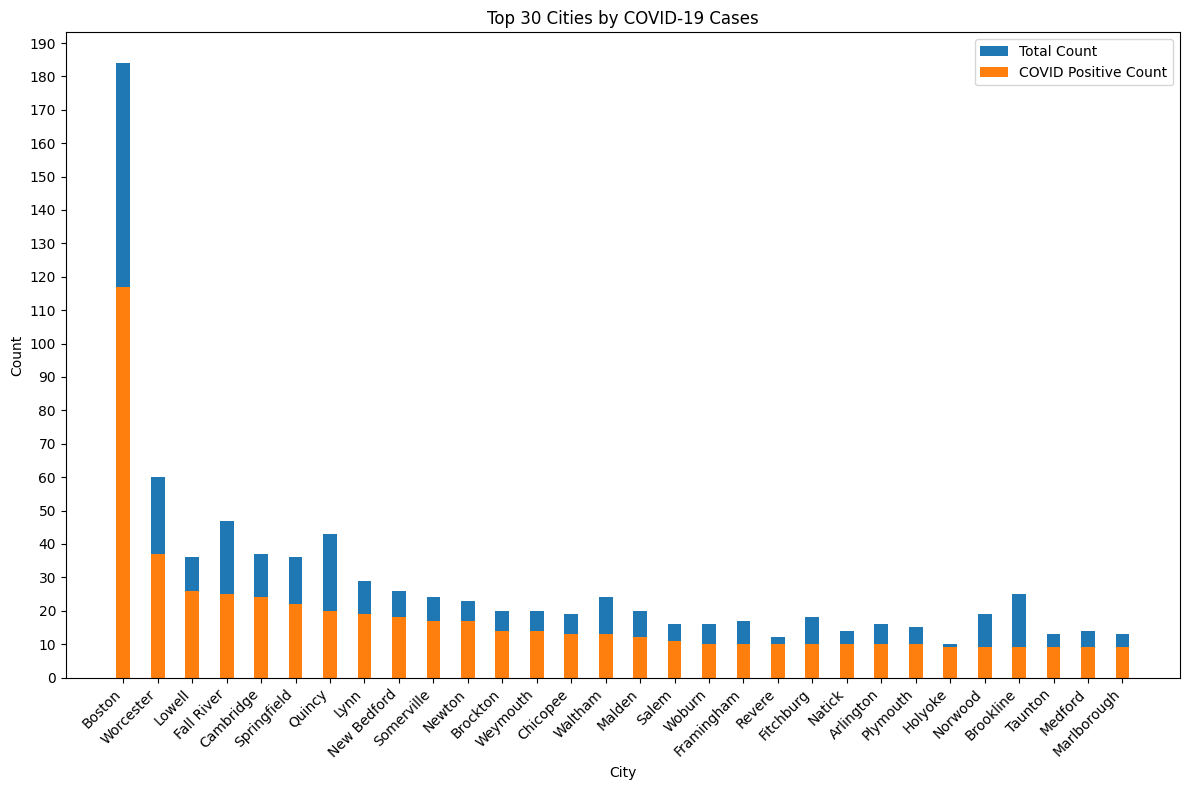

In [ ]:
plot_covid_city_counts(state_city_counts_df, top_n=30)

**Temporal analysis of covid cases by reagion**

This analysis shows how covid cases has spread.<br>
It will show if cases start in one city, then spread to another, or it will show that cases spread evenly around the states



In [ ]:
def get_covid_accumulative_trends(df):
  """
  Returns cumulative counts of COVID-positive cases over time, grouped by date, state, and city.

  Args:
    df (DataFrame): Input patient records DataFrame.

  Returns:
    DataFrame: A DataFrame with cumulative COVID-19 counts.
  """
  # Filter valid COVID-19 positive cases and valid encounter dates
  covid_positive_df = df.filter(
      (col("laboratory.covid19.result") == "Detected (qualifier value)"))

  # Convert encounter date to a valid date format
  covid_positive_df = covid_positive_df.withColumn(
      "encounter_date", to_date(col("encounter.date"), "yyyy-MM-dd")
  )

  # Group by encounter date, state, and city; count COVID-positive cases
  covid_trends = (
    covid_positive_df.groupBy(
      col("encounter_date"),
      col("demographics.address.state").alias("state"),
      col("demographics.address.city").alias("city")
    )
    .agg(count("*").alias("covid_positive_count"))
  )

  # Define window to calculate cumulative sum over time for each city
  window_spec = Window.partitionBy("state", "city").orderBy("encounter_date")

  # Add cumulative count column
  covid_trends = covid_trends.withColumn(
    "cumulative_count", spark_sum("covid_positive_count").over(window_spec)
  )

  return covid_trends.orderBy("state", "city", "encounter_date")


In [ ]:
covid_accumulative_trends_df = get_covid_accumulative_trends(df)
covid_accumulative_trends_df.show(truncate=False)

+--------------+-------------+--------+--------------------+----------------+
|encounter_date|state        |city    |covid_positive_count|cumulative_count|
+--------------+-------------+--------+--------------------+----------------+
|2020-03-04    |Massachusetts|Abington|1                   |1               |
|2020-03-11    |Massachusetts|Abington|1                   |2               |
|2020-04-27    |Massachusetts|Abington|1                   |3               |
|2020-05-24    |Massachusetts|Abington|1                   |4               |
|2020-05-25    |Massachusetts|Abington|1                   |5               |
|2020-02-23    |Massachusetts|Acton   |1                   |1               |
|2020-02-29    |Massachusetts|Acton   |1                   |2               |
|2020-03-15    |Massachusetts|Acton   |1                   |3               |
|2020-03-16    |Massachusetts|Acton   |1                   |4               |
|2020-05-24    |Massachusetts|Acton   |1                   |5   

In [ ]:
def plot_cumulative_covid_trends(covid_accumulative_trends_df, top_n=10):
  """
  Plot cumulative COVID-positive case trends for the top cities.

  Args:
    covid_accumulative_trends_df (DataFrame): Spark DataFrame with encounter_date, state, city, and cumulative counts.
    top_n (int): Number of top cities to include in the plot.
  """
  # Convert Spark DataFrame to Pandas DataFrame
  pandas_df = covid_accumulative_trends_df.toPandas()

  # Aggregate to get the total cumulative count for each city
  top_cities = (
    pandas_df.groupby("city")["cumulative_count"]
    .max()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
  )

  # Filter data for the top cities
  filtered_df = pandas_df[pandas_df["city"].isin(top_cities)]

  # Pivot the data for plotting
  pivot_df = filtered_df.pivot_table(
    index="encounter_date", columns="city", values="cumulative_count", aggfunc="max"
  ).fillna(method='ffill')  # Fill forward missing values for a smooth line

  # Plot cumulative trends
  plt.figure(figsize=(14, 8))
  for city in pivot_df.columns:
      plt.plot(pivot_df.index, pivot_df[city], label=city)

  # Chart styling
  plt.title(f"Cumulative COVID-19 Case Trends for Top {top_n} Cities")
  plt.xlabel("Date")
  plt.ylabel("Cumulative COVID-19 Case Count")
  plt.xticks(rotation=45)
  plt.legend(title="City", loc="upper left", bbox_to_anchor=(1, 1))
  plt.grid()
  plt.tight_layout()

  # Show the plot
  plt.show()


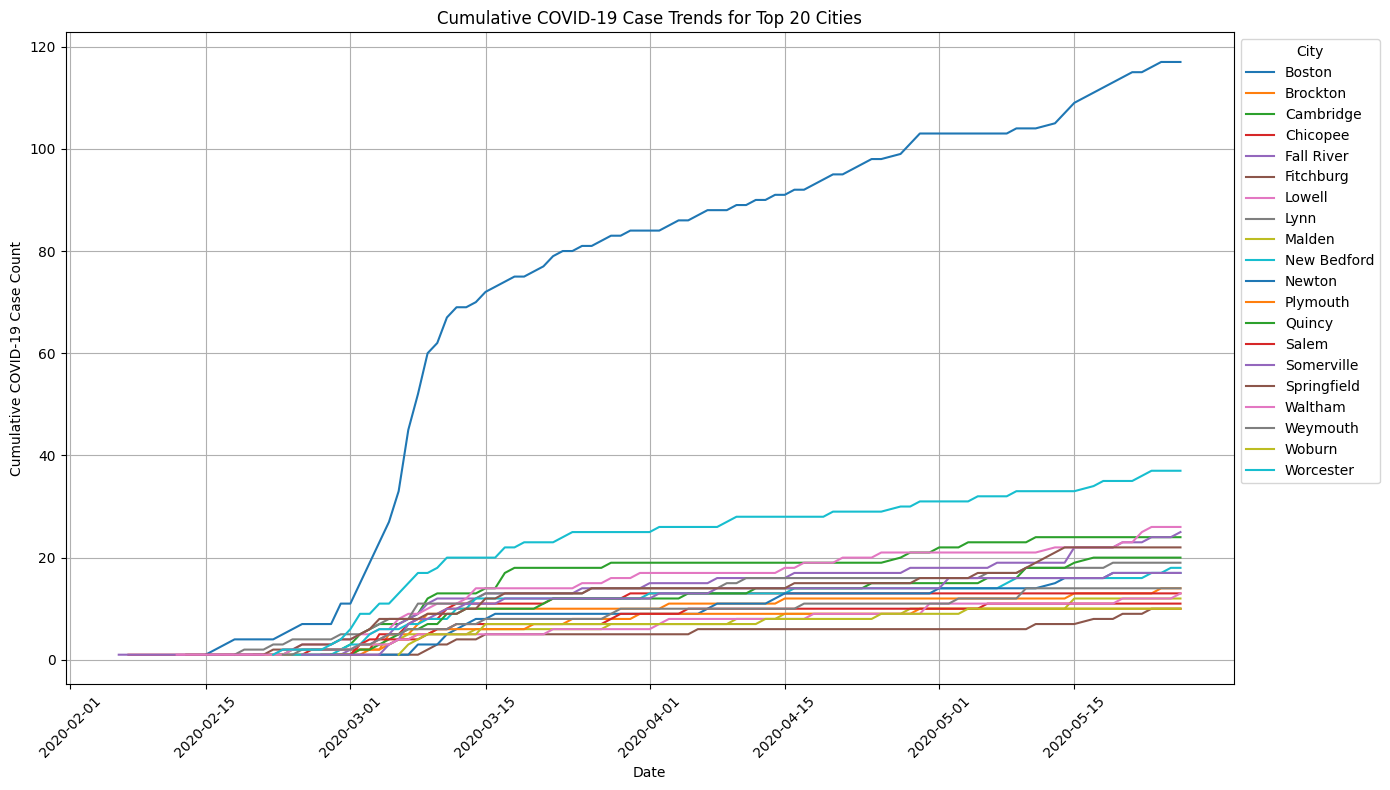

In [ ]:
plot_cumulative_covid_trends(covid_accumulative_trends_df, top_n=20)

**Vitals for covid patients vs non-covid patents**

It is very interesting to know whcih vitals are being affected by the decease, not only to treat it but to find out what are common symptoms so that peaple can notice it earlier. 

In [ ]:
def get_age_group_vital_averages(df):
  """
  Returns average vitals for confirmed COVID-19 patients and non-COVID patients grouped by age buckets.

  Args:
    df (DataFrame): The input DataFrame containing patient records.

  Returns:
    DataFrame: A DataFrame with columns:
    - age_bucket: Age group bucket (e.g., 0-5, 6-10, etc.).
    - systolic: Average systolic blood pressure for non-COVID patients.
    - covid_systolic: Average systolic blood pressure for COVID-19 positive patients.
    - diastolic: Average diastolic blood pressure for non-COVID patients.
    - covid_diastolic: Average diastolic blood pressure for COVID-19 positive patients.
    - respiratory_rate: Average respiratory rate for non-COVID patients.
    - covid_respiratory_rate: Average respiratory rate for COVID-19 positive patients.
    - oxygen_saturation: Average oxygen saturation for non-COVID patients.
    - covid_oxygen_saturation: Average oxygen saturation for COVID-19 positive patients.
    - temperature: Average temperature for non-COVID patients.
    - covid_temperature: Average temperature for COVID-19 positive patients.
  """
  # UDF for age bucket
  def age_bucket(age):
    if age <= 5: return "0-5"
    elif age <= 10: return "6-10"
    elif age <= 15: return "11-15"
    elif age <= 20: return "16-20"
    elif age <= 30: return "21-30"
    elif age <= 50: return "31-50"
    elif age <= 70: return "51-70"
    else: return "71+"

  age_udf = udf(age_bucket, StringType())

  # Add age bucket column
  df = df.withColumn("age_bucket", age_udf(col("demographics.age")))

  # Filter COVID-19 positive and non-COVID records
  covid_df = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")
  non_covid_df = df.filter(col("laboratory.covid19.result") != "Detected (qualifier value)")

  # Aggregate COVID vitals by age bucket
  covid_agg = (
    covid_df.groupBy("age_bucket")
    .agg(
      round(avg("vitals.current.blood_pressure.systolic.value"), 2).alias("covid_systolic"),
      round(avg("vitals.current.blood_pressure.diastolic.value"), 2).alias("covid_diastolic"),
      round(avg("vitals.current.respiratory_rate.value"), 2).alias("covid_respiratory_rate"),
      round(avg("vitals.current.oxygen_saturation.value"), 2).alias("covid_oxygen_saturation"),
      round(avg("vitals.current.temperature.value"), 2).alias("covid_temperature")
    )
  )

  # Aggregate non-COVID vitals by age bucket
  non_covid_agg = (
    non_covid_df.groupBy("age_bucket")
    .agg(
      round(avg("vitals.current.blood_pressure.systolic.value"), 2).alias("systolic"),
      round(avg("vitals.current.blood_pressure.diastolic.value"), 2).alias("diastolic"),
      round(avg("vitals.current.respiratory_rate.value"), 2).alias("respiratory_rate"),
      round(avg("vitals.current.oxygen_saturation.value"), 2).alias("oxygen_saturation"),
      round(avg("vitals.current.temperature.value"), 2).alias("temperature")
    )
  )

  # Join the results
  result = non_covid_agg.join(covid_agg, on="age_bucket", how="outer").orderBy("age_bucket")

  return result


In [ ]:
age_group_vital_averages_df = get_age_group_vital_averages(df)
age_group_vital_averages_df.show(truncate=False)

+----------+--------+---------+----------------+-----------------+-----------+--------------+---------------+----------------------+-----------------------+-----------------+
|age_bucket|systolic|diastolic|respiratory_rate|oxygen_saturation|temperature|covid_systolic|covid_diastolic|covid_respiratory_rate|covid_oxygen_saturation|covid_temperature|
+----------+--------+---------+----------------+-----------------+-----------+--------------+---------------+----------------------+-----------------------+-----------------+
|0-5       |125.33  |79.67    |15.33           |77.23            |39.07      |117.42        |80.32          |14.42                 |83.3                   |40.3             |
|11-15     |118.9   |78.4     |23.71           |85.63            |38.61      |119.21        |78.97          |23.09                 |81.25                  |39.91            |
|16-20     |118.0   |78.64    |27.81           |81.23            |37.16      |118.33        |80.26          |24.38           

In [ ]:
import matplotlib.pyplot as plt

def plot_vitals_comparison(df):
  """
  Visualizes average vitals for COVID and non-COVID patients grouped by age buckets.
  """
  # Convert Spark DataFrame to Pandas DataFrame
  pdf = df.toPandas()

  # Set up the figure and axes for subplots
  fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3 rows, 2 columns for 6 charts
  fig.suptitle("Comparison of Vitals: COVID-19 vs Non-COVID Patients", fontsize=16)

  # Define the metrics to plot
  metrics = [
    ("systolic", "covid_systolic", "Systolic Blood Pressure"),
    ("diastolic", "covid_diastolic", "Diastolic Blood Pressure"),
    ("respiratory_rate", "covid_respiratory_rate", "Respiratory Rate"),
    ("oxygen_saturation", "covid_oxygen_saturation", "Oxygen Saturation"),
    ("temperature", "covid_temperature", "Temperature")
  ]

  # Plot each metric
  for i, (non_covid_col, covid_col, title) in enumerate(metrics):
    ax = axes[i // 2, i % 2]  # Determine subplot position
    ax.bar(pdf["age_bucket"], pdf[non_covid_col], label="Non-COVID", alpha=0.7)
    ax.bar(pdf["age_bucket"], pdf[covid_col], label="COVID", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Age Group")
    ax.set_ylabel("Average Value")
    ax.legend()

  # Adjust layout and show the plots
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
  plt.show()


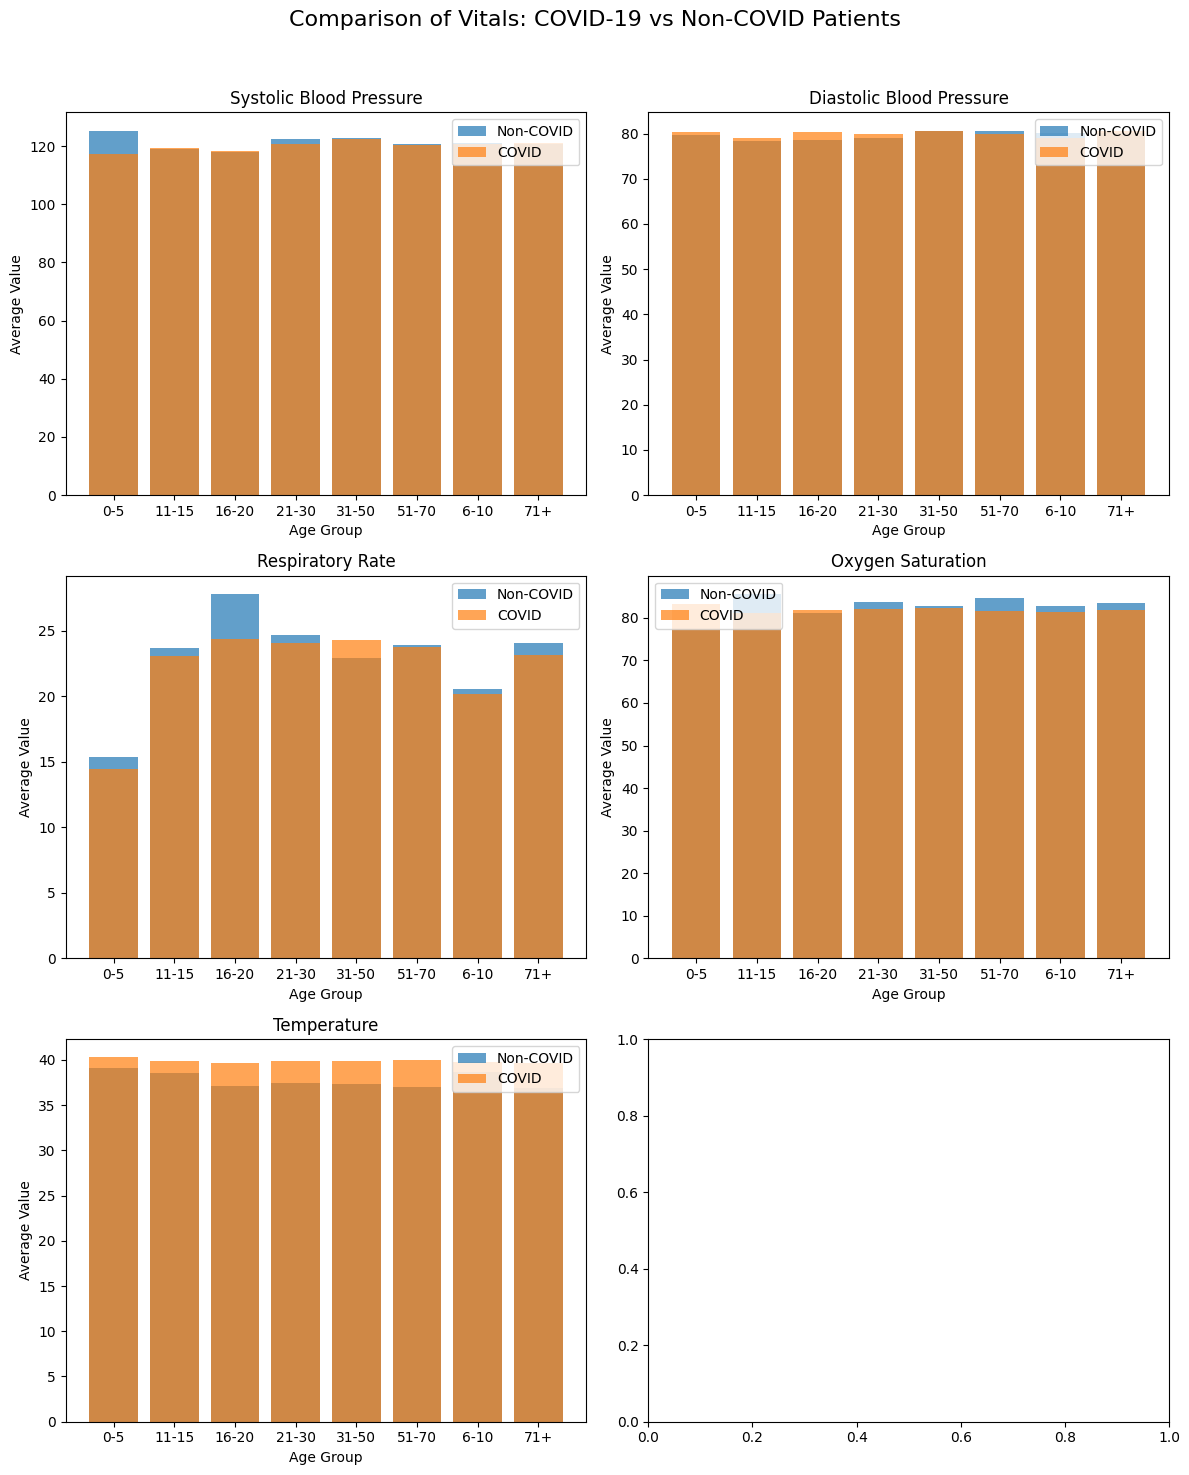

In [ ]:
plot_vitals_comparison(age_group_vital_averages_df)